# Predicting binding affinity of SARS-CoV-2 Main Protease ligands in Covid Moonshot project

### Henriette Capel, Yiming Wei

### 2023-01-27

In [1]:
# Load packages
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model
import sklearn.metrics
import sklearn.ensemble
import sklearn.svm
import scipy
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline
import plotnine
import seaborn

from matplotlib import pyplot as plt
plt.style.use('ggplot')

## Background
### 1.1 SARS-CoV-2 Main Protease

> SARS-CoV-2 is a single stranded RNA coronavirus. The main protease is $M^{pro}$. 
> Molecules binding $M^{pro}$ specifically will avoid off-target binding to human proteases and therefore $M^{pro}$ is an ideal drug target.
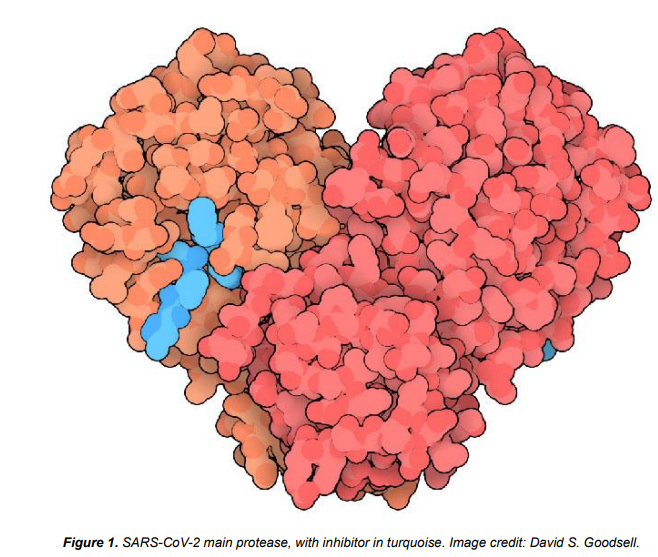

Aim of the project: predicting binding affinity of $M^{pro}$ ligands using Covid Moonshot data

## Data Exploration
### 2.1 Extracting features from SMILES strings

In [2]:
# Import dataset
data_file = 'activity_data.csv'
df_temp = pd.read_csv(data_file)
assays = df_temp[['CID','r_inhibition_at_20_uM','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_20_uM','f_inhibition_at_50_uM','f_avg_IC50','f_avg_pIC50']]
compounds = df_temp[['CID','SMILES']]

**SMILES**
> - SMILES string are line notations that describe the structure of a chemical molecule  
> - Our dataset consist of compounds, small molecules potentially inhibiting $M^{pro}$, represented by their SMILES string  
> - We have 2062 compounds in the dataset  

In [3]:
import rdkit.Chem as Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors
from rdkit.Chem import AllChem
from rdkit.DataStructs import FingerprintSimilarity,DiceSimilarity

**Molecular descriptors**
> - We can featurize the inhibotrs using the molecular descriptors of the RDkit package  
> - Lipinski's rule of five is a rule of thumb to asses the oral bioavailability of a small molecule  
> - We looked at the following four criteria:  
>    ● 5 or fewer hydrogen bond donors;  
>    ● 10 or fewer hydrogen bond acceptors;  
>    ● A molecular weight (MW) of less than 500 Daltons;  
>    ● An octanol-water partition coefficient (log Po/w) of less than 5.  
> - 1539 of our compounds met all four criteria, 1974 met at least three. 

In [4]:
def calculate_descriptors(smile):
    '''
    Function to calculate the molecular descriptors for Lipinski's rule of five.
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    '''
    
    molecule = Chem.MolFromSmiles(smile)
    if molecule:
        hbd, hba, mw, logpow = [x(molecule) for x in [NumHDonors, NumHAcceptors, MolWt, MolLogP]]
        res = [hbd, hba, mw, logpow]
    else:
        res = [None] * 4
    return res

In [5]:
# Add molecular descriptors to compounds table
hbd, hba, mw, logpow =[],[],[],[]
for i in range(len(compounds)):
    hbd_temp, hba_temp, mw_temp, pow_temp = calculate_descriptors(compounds['SMILES'][i])
    hbd.append(hbd_temp)
    hba.append(hba_temp)
    mw.append(mw_temp)
    logpow.append(pow_temp)
compounds['hbd'] = hbd
compounds['hba'] = hba
compounds['mw'] = mw
compounds['pow'] = logpow

C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [6]:
# Select compounds based on Lipinski's rule of five
print('Total number of compounds: ',len(compounds))
compounds_lip_strict = compounds.loc[(compounds['hbd']<=5) & (compounds['hba']<=10) & (compounds['mw']<500) & (compounds['pow']<5)]
print('Number of compounds after selected by Lipinski rule: ',len(compounds_lip_strict))
compounds_lip = compounds[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]
assays_lip = assays[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]
print('Number of compounds after less strict lipinski rule: ',len(compounds_lip))

Total number of compounds:  2062
Number of compounds after selected by Lipinski rule:  1539
Number of compounds after less strict lipinski rule:  1974


### 2.2 Fingerprints and similarity
> - ECFP are topological fingerproints for molecular characterization.  
> - radius: how much 'local' information captured by fingerprint. So the bigger the larger the substructures.
> - bit vector length: number of bits in the fingerprint
> - usechirality = True.

In [7]:
def ECFP(smile,radius=2,nBits=2048):
    '''
    Function to determine the ECFP (Morgan) fingerprints.
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    radius: integer
        Measure of the 'local' information captured by the fingerprint
    nBits = integer
        length of the fingerprint
    '''
    
    molecule = Chem.MolFromSmiles(smile)
    return AllChem.GetMorganFingerprintAsBitVect(molecule,radius,nBits=nBits,useChirality=True)

In [8]:
# Add ECFP to the compounds table 
ECFP_temp = []
for i in range(len(compounds)):
    ECFP_temp.append(ECFP(compounds['SMILES'][i]))
compounds['ECFP'] = ECFP_temp

C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
compounds.head()

,CID,SMILES,hbd,hba,mw,pow,ECFP
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,1,5,498.992,2.7033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,1,5,525.030,3.0934,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,1,4,448.910,2.7647,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Fingerprint similarity**
> - Similarity between fingerprints can be captured by the Tanimoto index.
> - ratio of the intersetion of the two sets over the union of the two sets
> - We created a similarity matrix and clusterd this using the seaborn.clustermap() function

In [10]:
def compute_similarity(fingerprint_1,fingerprint_2):
    '''
    Function to compute the Tanimoto (a.k.a. Jaccard) index between two fingerprints
    
    Parameters
    ----------
    fingerprint_1: 
        Bit vector representing a chemical molecular structure
    fingerprint_2: 
        Bit vector representing a chemical molecular structure
    '''
    
    return FingerprintSimilarity(fingerprint_1,fingerprint_2, metric=DiceSimilarity)

In [11]:
# Construct similarity matrix of the Tanimoto index values
similarity_matrix = np.zeros((len(compounds),len(compounds)))
for i in range(len(compounds)):
    for j in range(len(compounds)):
        similarity_matrix[i,j] = compute_similarity(compounds['ECFP'][i],compounds['ECFP'][j])

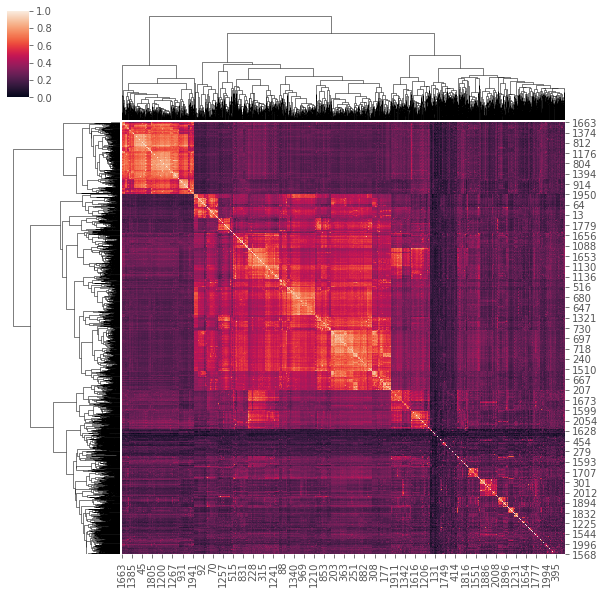

In [12]:
#Create cluster of Tanimoto index
res_dendogram = seaborn.clustermap(similarity_matrix)

**Highly similar molecules**
> - We visualised the two molecules with the higest Tanimoto index. 

In [13]:
# determine the indices with the higest similarity score
from rdkit.Chem import Draw
from collections import Counter

#Determine the highest similarity score
dict_occurence_similarityscore = Counter(similarity_matrix.flatten())
sorted_dict_occurence_ss = dict(sorted(dict_occurence_similarityscore.items()))
for x in list(sorted_dict_occurence_ss)[-2:-1]:
    print('{}: {}'.format(x, sorted_dict_occurence_ss[x]))
    highest_score = x

#determine the indices with the highest similarity score
i, j = np.where(np.isclose(similarity_matrix, highest_score))
print('Index of highest similarity score: x: {}, y: {}'.format(i[0], j[0]))

0.9855072463768116: 2
Index of highest similarity score: x: 346, y: 698


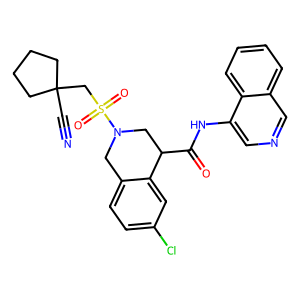

In [14]:
#draw the highly similar structures
m1 = Chem.MolFromSmiles(compounds['SMILES'][i[0]])
Draw.MolToImage(m1)

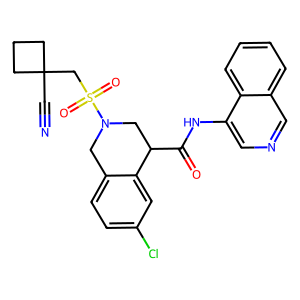

In [15]:
m2 = Chem.MolFromSmiles(compounds['SMILES'][j[0]])
Draw.MolToImage(m2)

In [16]:
CID_m1 = compounds['CID'][i[0]]
print(assays.loc[assays['CID'] == CID_m1])

CID_m2 = compounds['CID'][j[0]]
print(assays.loc[assays['CID'] == CID_m2])

                    CID  r_inhibition_at_20_uM  r_inhibition_at_50_uM  \
346  MAT-POS-5cd9ea36-5                    NaN                    NaN   

     r_avg_IC50  f_inhibition_at_20_uM  f_inhibition_at_50_uM  f_avg_IC50  \
346         NaN                    NaN                    NaN    0.083698   

     f_avg_pIC50  
346          NaN  
                     CID  r_inhibition_at_20_uM  r_inhibition_at_50_uM  \
698  MAT-POS-4223bc15-12                    NaN                    NaN   

     r_avg_IC50  f_inhibition_at_20_uM  f_inhibition_at_50_uM  f_avg_IC50  \
698         NaN                    NaN                    NaN     0.05996   

     f_avg_pIC50  
698          NaN  


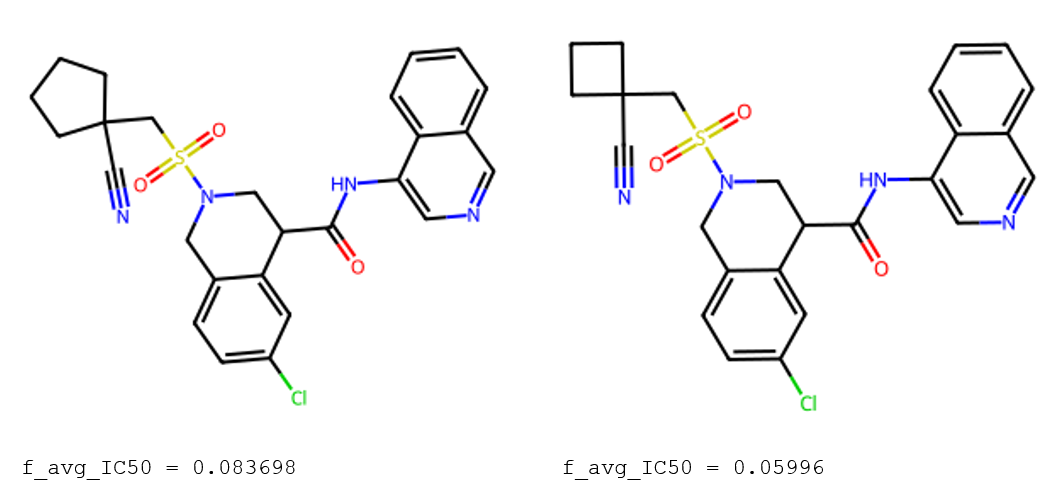

**Murcko Scaffolds**
> - represent core structures of bioactive compounds
> - scaffolds are generic and important structural features essential for pharmaceutical activity are not presented in these scaffolds
> - from rdkit.Chem.Scaffolds import MurckoScaffold
> - 19 scaffolds containing more than 10 compounds
> - for now to main clusters to split data on

In [17]:
from rdkit.Chem.Scaffolds import MurckoScaffold
def generate_murcko_scaffolds(smile):
    '''
    Function to determine the murcko scaffold
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    '''
    
    m = Chem.MolFromSmiles(smile)
    return Chem.MolToSmiles(Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(m))

In [18]:
# Store the Murcko scaffolds 
compounds_scaffold = compounds.copy()
mscaffold_temp = []
for i in range(len(compounds_scaffold)):
    mscaffold_temp.append(generate_murcko_scaffolds(compounds_scaffold['SMILES'][i]))
compounds_scaffold['murcko'] = mscaffold_temp

In [19]:
# Determine occurence of every Murcko scaffold
compounds_scaffold['murcko'].value_counts()

O=C(Cc1ccccc1)Nc1cncc2ccccc12                                    98
O=C(Nc1cncc2ccccc12)C1CCOc2ccccc21                               81
O=C(Nc1cncc2ccccc12)C1CNCc2ccccc21                               48
O=C1NCC(C(=O)Nc2cncc3ccccc23)c2ccccc21                           43
O=C(Cc1ccccc1)Nc1cccnc1                                          33
                                                                 ..
O=C(C(c1cccnc1)N(C(=O)c1cocn1)c1ccccc1)N1CCC(c2ccccc2)CC1         1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(-n2ccnn2)cc1      1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1ccon1)c1ccccc1                1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(N2CCCC2=O)cc1     1
O=C(Nc1ccccc1)Nc1c[nH]c2ncccc12                                   1
Name: murcko, Length: 1179, dtype: int64

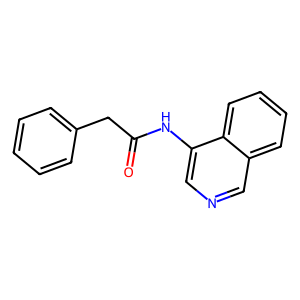

In [20]:
# Draw the structure of the most occuring Murcko scaffold
m = Chem.MolFromSmiles('O=C(Cc1ccccc1)Nc1cncc2ccccc12')
Draw.MolToImage(m)

### 2.3  Binding affinity metric
> - assays: fluorescence (f) and mass spectrometry (r)
> - Measured by $IC_{50}$ (half-maximal inhibitory concentration)
> - unit in databasedis mM (micromolar)
> - lower $IC_{50}$ less substance needed for inhibition. So low value perferred for making a drug

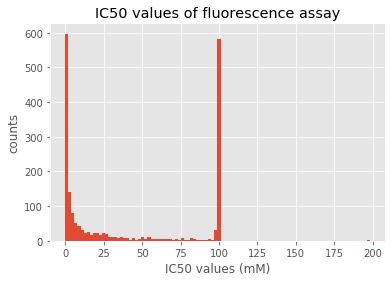

In [21]:
plt.hist(assays['f_avg_IC50'],bins=100);
plt.title("IC50 values of fluorescence assay");
plt.xlabel("IC50 values (mM)");
plt.ylabel("counts");

> - Determine the pIC50 to get closer to a normal distribution
> - $pIC_{50} = \log_{10}(IC_{50})$

In [22]:
# Compute pIC50:
assays['r_avg_pIC50'] = - np.log10(assays['r_avg_IC50']) + 6
assays['f_avg_pIC50'] = - np.log10(assays['f_avg_IC50']) + 6

C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


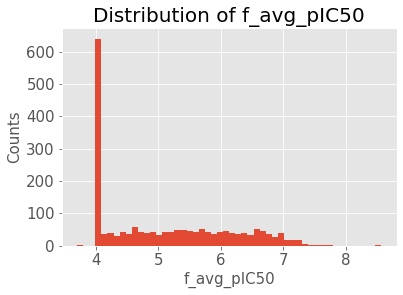

In [23]:
# plot distribution of f_avg_IC_50
plt.figure()
plt.hist(assays['f_avg_pIC50'],bins=50);
plt.title('Distribution of f_avg_pIC50',fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('f_avg_pIC50',fontsize=15);
plt.ylabel('Counts',fontsize=15);

In [24]:
# Import dataset
data_file = 'activity_data.csv'
df_raw = pd.read_csv(data_file)

In [25]:
f_and_r = np.sum((~np.isnan(df_raw['f_avg_IC50'])& ~np.isnan(df_raw['r_avg_IC50'])))
f_and_no_r = np.sum((~np.isnan(df_raw['f_avg_IC50'])& np.isnan(df_raw['r_avg_IC50'])))
no_f_and_r = np.sum((np.isnan(df_raw['f_avg_IC50'])& ~np.isnan(df_raw['r_avg_IC50'])))
no_f_and_no_r = np.sum((np.isnan(df_raw['f_avg_IC50'])& np.isnan(df_raw['r_avg_IC50'])))

#calculate pIC50
df_raw['f_avg_pIC50'] = - np.log10(df_raw['f_avg_IC50']) + 6
df_raw['r_avg_pIC50'] = - np.log10(df_raw['r_avg_IC50']) + 6

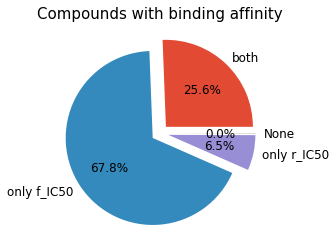

In [26]:
# plot how many data have
plt.figure();
labels = ['both','only f_IC50','only r_IC50','None'];
data = [f_and_r,f_and_no_r,no_f_and_r,no_f_and_no_r];
explode = [0.1,0.1,0.1,0.1];
plt.pie(data,explode=explode,labels=labels,autopct='%1.1f%%', textprops={'fontsize': 12});
plt.title('Compounds with binding affinity',fontsize=15);

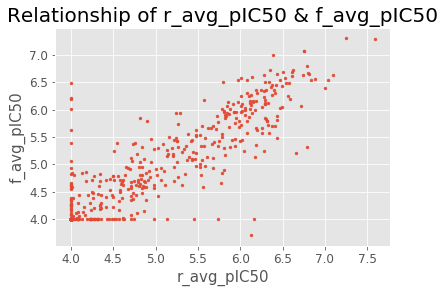

In [27]:
# plot correlation of f_avg_IC_50, r_avg_IC_50
plt.figure();
plt.scatter(df_raw['r_avg_pIC50'],df_raw['f_avg_pIC50'],s=8);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('r_avg_pIC50',fontsize=15);
plt.ylabel('f_avg_pIC50',fontsize=15);
plt.title('Relationship of r_avg_pIC50 & f_avg_pIC50',fontsize=20);

**Summary assay values**
* most compounds have f_avg_pIC50 (1926/2062)
* f_avg_pIC50 and r_avg_pIC50 are highly correlated with some expections
* f_avg_pIC50 has a nearly uniform distribution expect at value 4.0

### 2.2  Dataset filtering
* Create two dataset: random split and split based on the three clusters
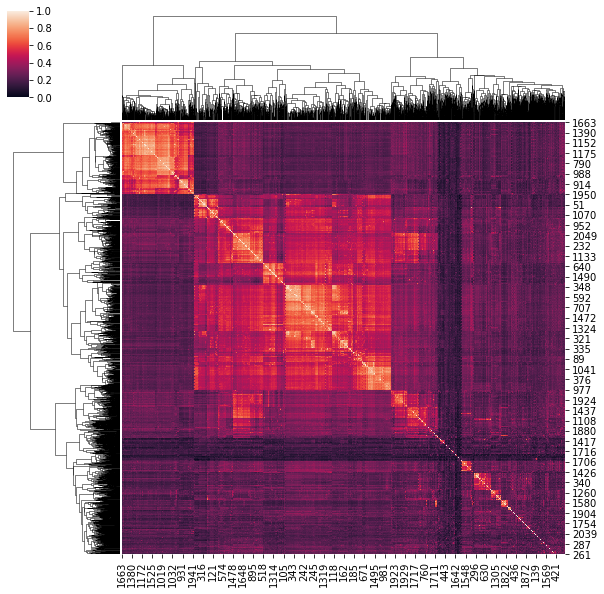

**Stratified splitting based on fingerprint clusters**  

| Cluster | Classification | Regression |
| --- | --- | --- |
| 1 | 337  | 176 |
| 2 | 912 | 842 |
| 3 | 813 | 298 |

So, many non binding compounds in the first and second cluster. 

**Dataset**
* Create two dataset: random split and split based on the three clusters
* Split in 80% training and 20% test

| Machine learning type | set | Random Splitting | Cluster-based Splitting|
| --- | --- | --- | --- |
| Classification | train | 1540  | 1538 |
| Classification | test | 386 | 388 |
| Regression     | train | 1051 | 1051 |
| Regression     | test | 264 | 265 |


**Dataset**
* Create two dataset: random split and split based on the three clusters
* Split in 80% training and 20% test
* Input of ML models are the 208 molecular descriptors of RDkit
* Only use the compounds with the f_avg_pIC50 values
* classification task: on binding or not, use the threshold of $pIC_{50}=5.0$ (915 binding, 1011 not binding)
* regression task: filters out compounds with $pIC_{50}>-\log_{10}(99*10^{-6})$. Because these datapoints will bias the predictors.
* regression dataset will be a subset of the classification dataset

In [28]:
print('binding compounds: ',np.sum(df_raw['f_avg_pIC50']>5.0))
print('not binding compounds: ',np.sum(df_raw['f_avg_pIC50']<=5.0))
print('Total number of compounds analysed: ',np.sum(df_raw['f_avg_pIC50']>5.0) + np.sum(df_raw['f_avg_pIC50']<=5.0))


binding compounds:  915
not binding compounds:  1011
Total number of compounds analysed:  1926


### 2.3 Summary of tasks
* Feature selection: 208 molecular descriptors
* Label:  binding/not binding(classification), f_avg_pIC50 (regression)
* Train/Test data splitting(80/20)
  1. random splitting
  2. stratified splitting based on fingerprint clusters
* Method
  1. Classification: Logistic Regression, Random Forest, Support Vector Machine
  2. Regression: Linear Regression, Support Vector Regression

## Model Construction
> Note: We used the package sklearn


In [29]:
def load_preprocessed_data(task_type,splitting_type):
    if splitting_type == 'random':
        splitting_str = ''
    else:
        splitting_str = '_cluster'
        
    X_train = pd.read_csv('X' + splitting_str + '_train_' + task_type+ '.csv',index_col=0)
    descriptors_set = list(X_train.columns.values)
    
    X_train = X_train.to_numpy()
    X_test = pd.read_csv('X' + splitting_str + '_test_' + task_type+ '.csv',index_col=0).to_numpy()
    y_train = np.load('Y' + splitting_str + '_train_' + task_type+ '.npy')
    y_test = np.load('Y' + splitting_str + '_test_' + task_type+ '.npy')
    
    
    return X_train, y_train, X_test, y_test, descriptors_set
            

class ClassificationModel():
    def __init__(self,X_train,y_train,X_test,y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def train_and_test(self,model_name, feature_scaling=False,hyperparameter_tuning=False):
        self.feature_scaling = feature_scaling
        if model_name == 'logistic_regression':
            self.model = sklearn.linear_model.LogisticRegression()
            # Compulsory feature scaling
            self.feature_scaling = True
        elif model_name == 'random_forest':
            self.model = sklearn.ensemble.RandomForestClassifier()
        elif model_name == 'SVM':
            self.model = sklearn.svm.SVC(probability=True)
            self.feature_scaling = True
        else:
            raise ValueError('We have not implemented the method!')
            
        if self.feature_scaling:
            scaler = sklearn.preprocessing.StandardScaler().fit(self.X_train)
            X_train = scaler.transform(self.X_train)
            X_test = scaler.transform(self.X_test)
        else:
            X_train = self.X_train
            X_test = self.X_test
            
        self.model.fit(X_train,self.y_train)
        y_pred = self.model.predict(X_test)
        y_pred_prob = np.squeeze(self.model.predict_proba(self.X_test)[:,1])
        
        accuracy = sklearn.metrics.accuracy_score(self.y_test, y_pred)
        confusion_matrix = sklearn.metrics.confusion_matrix(self.y_test,y_pred)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(self.y_test, y_pred_prob, pos_label=1)   
        roc_score = sklearn.metrics.roc_auc_score(self.y_test, y_pred_prob)
        
        
        result = {'accuracy':accuracy,
                 'confusion_matrix':confusion_matrix,
                 'fpr': fpr,
                 'tpr':tpr,
                 'thresholds':thresholds,
                 'roc_score':roc_score}
        
        return result
        
    def plot_result(self,result,model_name):
        # Plot confusion matrix
        confusion_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'],display_labels=['not binding','binding'])
        confusion_display.plot()
        plt.title('Confusion_matrix for ' +  model_name)
        
        # Plot roc_curve
        if self.feature_scaling: 
            sklearn.metrics.plot_roc_curve(self.model, sklearn.preprocessing.StandardScaler().fit(self.X_train).transform(self.X_test), self.y_test)
        else:
            sklearn.metrics.plot_roc_curve(self.model,self.X_test, self.y_test)
        plt.title('ROC curve for ' +  model_name)
        
            
        
                    
    
    def analyse(self,model_name,descriptors_set):
        if model_name == 'random_forest':
            # We analyse the contribution of different features
            importances = self.model.feature_importances_
            std = np.std([tree.feature_importances_ for tree in self.model.estimators_], axis=0)
            forest_importances = pd.Series(importances, index=descriptors_set)
            
            analyse_df = pd.DataFrame({'descriptor':descriptors_set,
                                       'importance':forest_importances,
                                       'std:': std})
            
            analyse_df_ten_largest = analyse_df.nlargest(10, 'importance')
            
            print(analyse_df_ten_largest)
            

            fig, ax = plt.subplots()
            ax.set_title("Feature importances using MDI")
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout()
            
        else:
            warnings.warn("Nothing more to analyse in " + model_name)
    
class RegressionModel():
    def __init__(self,X_train,y_train,X_test,y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def train_and_test(self,model_name,feature_scaling=False,hyperparameter_tuning=False):
        self.feature_scaling = feature_scaling
        if model_name == 'linear_regression':
            self.model = sklearn.linear_model.LinearRegression()
            # Compulsory feature scaling
        elif model_name == 'SVR':
            self.model = sklearn.svm.SVR()
             # Compulsory feature scaling
            self.feature_scaling = True
        else:
            raise ValueError('We have not implemented the method!')
            
        if self.feature_scaling:
            scaler = sklearn.preprocessing.StandardScaler().fit(self.X_train)
            X_train = scaler.transform(self.X_train)
            X_test = scaler.transform(self.X_test)
        else:
            X_train = self.X_train
            X_test = self.X_test
            
        self.model.fit(X_train,self.y_train)
        y_pred = self.model.predict(X_test)
        
        mse = sklearn.metrics.mean_squared_error(self.y_test, y_pred)
        r2_score = sklearn.metrics.r2_score(self.y_test, y_pred)
        pearson_correlation = pearsonr(self.y_test,y_pred)
        
        
        result = {'mse':mse,
                  'r2_score':r2_score,
                  'pearson_correlation':pearson_correlation,
                  'y_test':self.y_test,
                  'y_pred':y_pred}
        return result
    
    def plot_result(self,result,model_name):
        plt.figure()
        plt.scatter(result['y_test'],result['y_pred'],s=10)
        plt.xlabel('pIC_50 true value',fontsize=20)
        plt.ylabel('pIC_50 prediction value',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.title('Results ' + model_name + ' ' + r'$\rho=$' +  "%.2f" %result['pearson_correlation'][0],fontsize=20)
    
    def analyse(self,model_name):
        pass

### 3.1 Classification
* threshold of $pIC_{50}=5.0$
* Logistic regression, Random Forest, Support Vectors machine
> Note: Without specifying, we work on random splitting data in section 3.1 and 3.2, and compare the difference of random splitting and stratified splitting in section 3.3

In [30]:
# Load data and construct the model class first
X_train, y_train, X_test, y_test, descriptors_set = load_preprocessed_data(task_type='classification',splitting_type='random')
cmodel = ClassificationModel(X_train,y_train,X_test,y_test)

#### 3.1.1 Logistic Regression
The possibility of classifying sample $X_i$ as positive is
$$
P(Y_i=1|X_i) = \sigma(\beta_0 + \sum_j \beta_j X_{ij})= \frac{1}{1+e^{-(\beta_0 + \sum_j \beta_j X_{ij})}}
$$

where $\beta_k (0 \leq  k \leq 208)$ are coefficients, and $X_{ij} (1\leq j\leq 208)$ are features.

Logistic Regression uses gradient descent to train, and needs feature scaling.

Package: sklearn.linear_model.LogisticRegression()

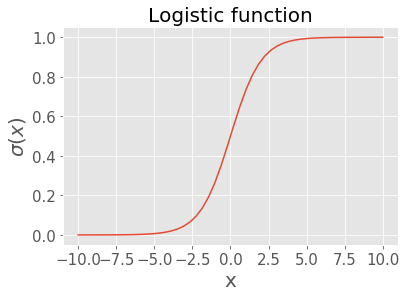

In [31]:
x = np.linspace(-10,10,50);
y = 1 / (1 + np.exp(-x));
plt.plot(x,y);
plt.xlabel('x',fontsize=20);
plt.ylabel(r'$\sigma(x)$',fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.title('Logistic function',fontsize=20);

Performance results of logistic regression on random sampled dataset
Accuracy: 0.7875647668393783


C:\Users\henri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


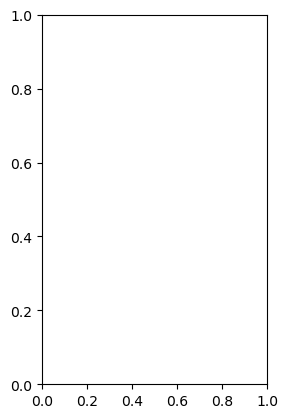

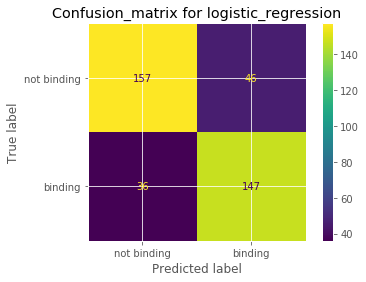

<Figure size 432x288 with 0 Axes>

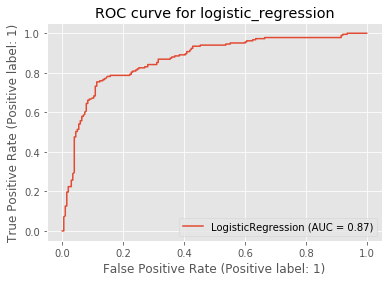

In [33]:
result = cmodel.train_and_test(model_name='logistic_regression');
print('Performance results of logistic regression on random sampled dataset') 
print('Accuracy: {}'.format(result['accuracy']))
cmodel.plot_result(result,model_name='logistic_regression');

#### 3.1.2 Random Forest Classification
* Decision trees: Use rules of features to reach the final decision (label) in a tree-like structure
* Random Forests: construct multitude decision trees, and use the label which is selected by most trees.

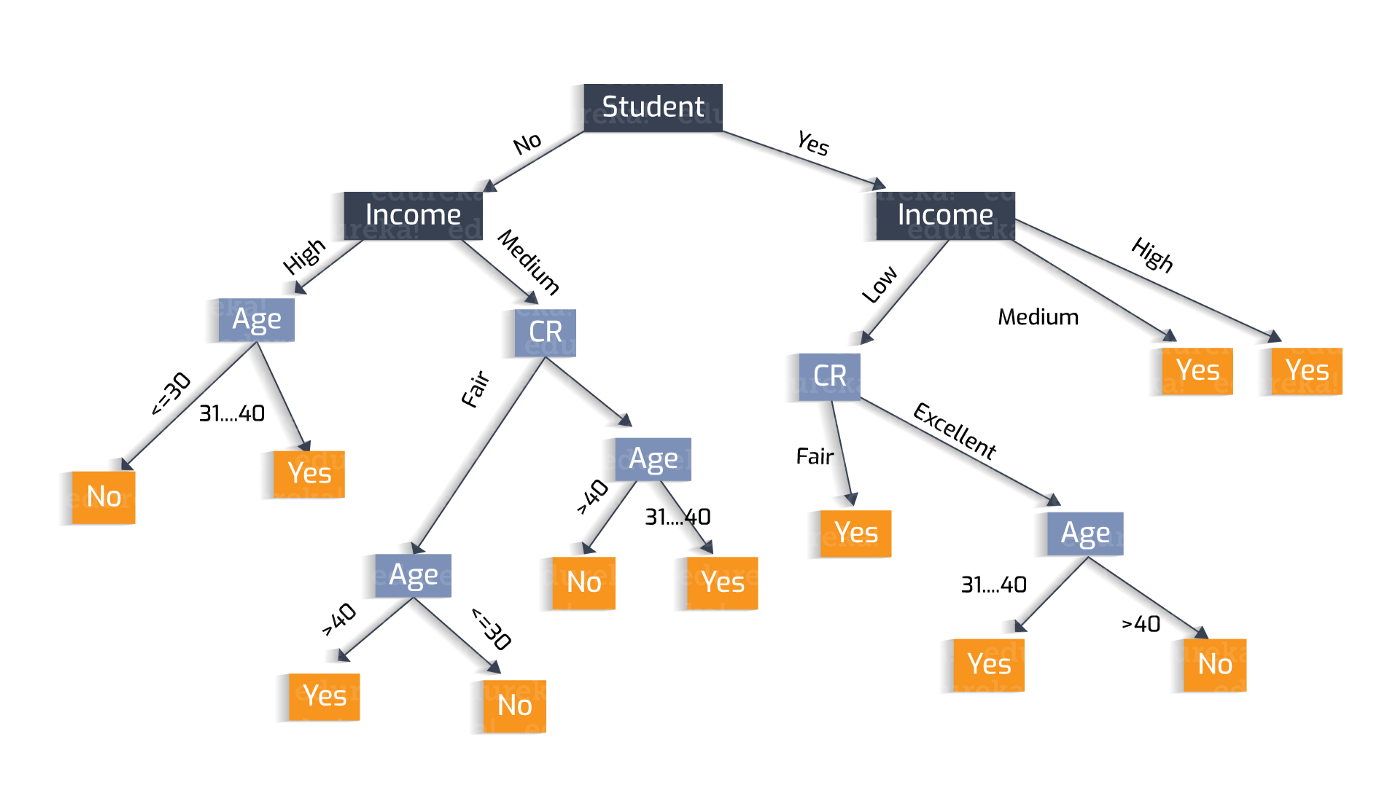

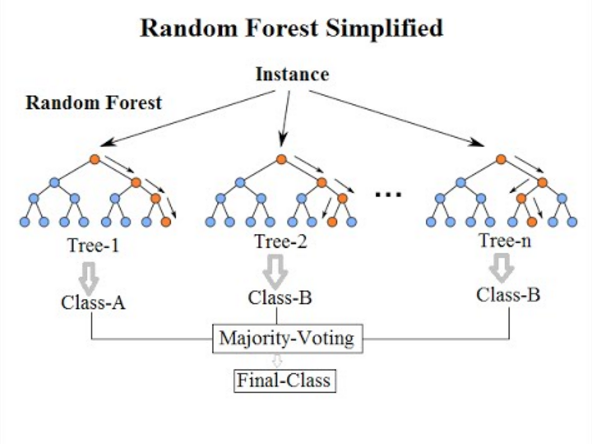

Performance results of random forest on random sampled dataset
Accuracy: 0.8082901554404145


<Figure size 432x288 with 0 Axes>

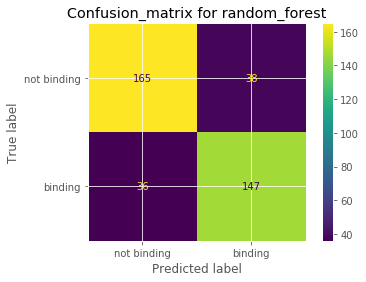

<Figure size 432x288 with 0 Axes>

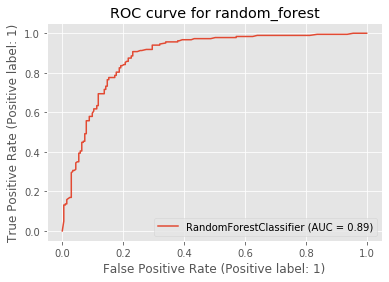

In [41]:
result = cmodel.train_and_test(model_name='random_forest')
print('Performance results of random forest on random sampled dataset')
print('Accuracy: {}'.format(result['accuracy']))
cmodel.plot_result(result,model_name='random_forest')

                descriptor  importance      std:
SMR_VSA10        SMR_VSA10    0.044851  0.069610
EState_VSA9    EState_VSA9    0.034069  0.064511
VSA_EState10  VSA_EState10    0.032783  0.062736
BCUT2D_MWHI    BCUT2D_MWHI    0.028443  0.061872
SlogP_VSA8      SlogP_VSA8    0.022904  0.043288
BCUT2D_MRHI    BCUT2D_MRHI    0.022865  0.042231
BCUT2D_CHGLO  BCUT2D_CHGLO    0.020216  0.032915
SlogP_VSA6      SlogP_VSA6    0.018359  0.036737
SMR_VSA7          SMR_VSA7    0.017737  0.023832
fr_bicyclic    fr_bicyclic    0.017449  0.043696


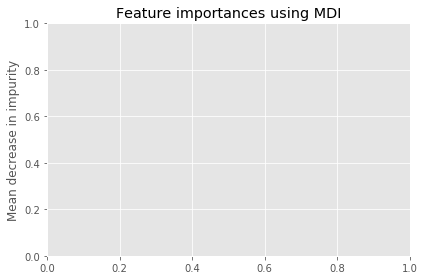

In [42]:
cmodel.analyse(model_name='random_forest',descriptors_set=descriptors_set)

**Feature importance**
> Note: Using Random Forest, we can work out the relative importance of features.

#### 3.1.3 Support Vector Machine
* Support Vector Machine looks for a maximum-margin hyperplane if datapoints are linear separable.
* By introducing kernel, SVM turns out to a powerful non-linear classifier
![SVM_margin.png](attachment:SVM_margin.png)

Performance results of Support Vector Machine on random sampled dataset
Accuracy: 0.8134715025906736


<Figure size 432x288 with 0 Axes>

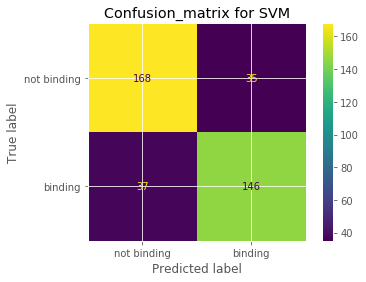

<Figure size 432x288 with 0 Axes>

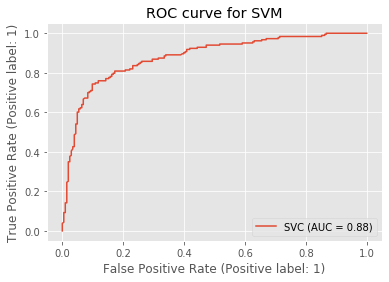

In [35]:
result = cmodel.train_and_test(model_name='SVM')
print('Performance results of Support Vector Machine on random sampled dataset')
print('Accuracy: {}'.format(result['accuracy']))
cmodel.plot_result(result,model_name='SVM')

### 3.2 Regression
* filters out compounds with  $𝑝𝐼𝐶_{50}>−log_{10}(99∗10^{−6})$
* Linear Regression, Support Vector Regression
> Note: Since $pIC_{50}$ value is over-represented near value $4$ ($IC_{50}$ near $100$), we dropped all compounds with $IC_{50}\geq 99$

In [36]:
# Load data and construct the model class first
X_train, y_train, X_test, y_test, descriptors_set = load_preprocessed_data(task_type='regression',splitting_type='random')
rmodel = RegressionModel(X_train,y_train,X_test,y_test)

#### 3.2.1 Linear Regression
Linear regression is a traditional model in statistics. Basically, it assumes a linear relationship between features $X_i$ and observation value $y_i$

$$
y_i = \beta_0 + \beta_1 X_{i1} + \cdots + \beta_{208}X_{i,208}+\epsilon_i
$$

where $\beta_i(0\leq i \leq 208)$ are parameters, $\epsilon_i$ is the error term.

Linear Regression can be solved by least squares method. There's no need for feature scaling.

Performance results of Linear Regression on random sampled dataset
Mean Squared Error:  0.5693669274307762
r2_score:  0.29868561180524156
Pearson Correlation:  0.5888585989216812


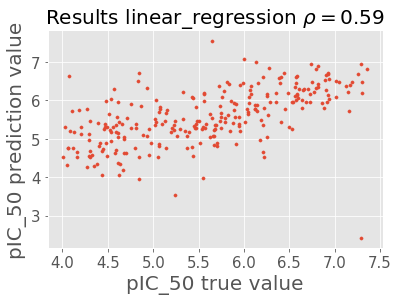

In [37]:
result = rmodel.train_and_test(model_name='linear_regression')
print('Performance results of Linear Regression on random sampled dataset')
print('Mean Squared Error: ',result['mse'])
print('r2_score: ', result['r2_score'])
print('Pearson Correlation: ',result['pearson_correlation'][0])
rmodel.plot_result(result,model_name='linear_regression')

#### 3.2.2 Support Vector Regression (SVR)
Support vector machine can also be used in regressions (called support vector regression). Mathematically, SVR deals with the following optimisation problem

$$
argmin_{\boldsymbol{\beta}} \frac{1}{2}\|\boldsymbol{\beta}\|^2\\
\text{s.t.} |y_i - \sum_j \beta_j X_{ij}|<\epsilon 
$$
where $epsilon$ is a hyperparameter.

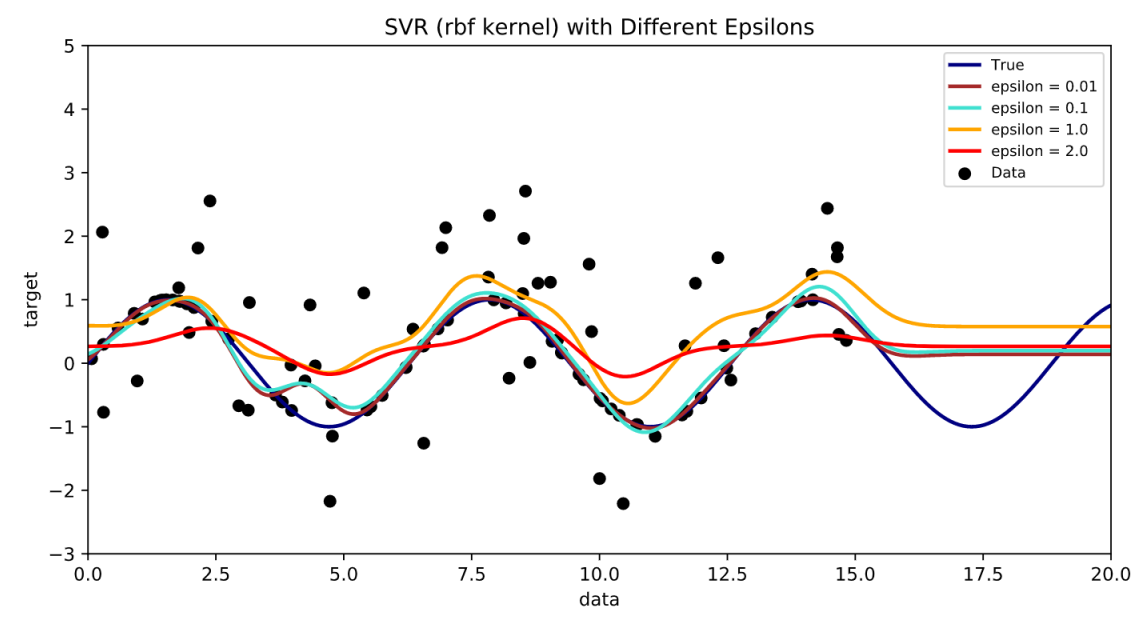

In [ ]:
result = rmodel.train_and_test(model_name='SVR')
print('Performance results of Support Vector Regression on random sampled dataset')
print('Mean Squared Error: ',result['mse'])
print('r2_score: ', result['r2_score'])
print('Pearson Correlation: ',result['pearson_correlation'])
rmodel.plot_result(result,model_name='SVR')

### 3.3 Comparison between different splitting strategies
> Recap: We've developed different strategies (random/cluster-based) for splitting the data. In this section, we analyse their difference.

In [43]:
def test_performance(splitting_type, model_list=['logistic_regression','random_forest','SVM','linear_regression','SVR']):
    split_performance = {}
    X_train, y_train, X_test, y_test, descriptors_set = load_preprocessed_data(task_type='classification',splitting_type=splitting_type)
    cmodel = ClassificationModel(X_train,y_train,X_test,y_test)
    rmodel = RegressionModel(X_train,y_train,X_test,y_test)
    
    for model in model_list:
        if model in ['logistic_regression','random_forest','SVM']:
            result = cmodel.train_and_test(model_name=model)
            split_performance[model] = result['accuracy']
        else:
            result = rmodel.train_and_test(model_name=model)
            split_performance[model] = result['pearson_correlation'][0]
    return split_performance


In [45]:
random_split_performance = test_performance('random')
cluster_split_performance = test_performance('cluster')

C:\Users\henri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\henri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [48]:
random_split_performance

{'logistic_regression': 0.7875647668393783,
 'random_forest': 0.8186528497409327,
 'SVM': 0.8134715025906736,
 'linear_regression': 0.4132308108574377,
 'SVR': 0.6641519909501665}

In [47]:
cluster_split_performance

{'logistic_regression': 0.7989690721649485,
 'random_forest': 0.7989690721649485,
 'SVM': 0.8144329896907216,
 'linear_regression': 0.4088318381399686,
 'SVR': 0.684586801517694}

| Method | Metric | Random Splitting | Cluster-based Splitting|
| --- | --- | --- | --- |
| Logistic Regression       | accuracy   | 0.788 | **0.799** |
| Random Forest             | accuracy   | **0.824** | 0.802 |
| Support Vector Machine    | accuracy   | 0.813 | **0.814** |
| Linear Regression         | correlation| 0.440 | **0.561** |
| Support Vector Regression | correlation| 0.664 | **0.685** |

Interpretation
* Results between random nd cluster splitting seem to be comparable.
* Cluster-splitting performances slightly better in regression problem.
* Future work: fine-tune these models, and split-and-train for multiple times to see how confident we're on the difference (Is there significant difference)

## Discussion and Future work
* choose the best hyperparameters by validation set.
* CHEMBL data and use the data of uploaded to make test and training.
* Use timestamp data to best represent and sample from the sample space.